# DS Processing

In this tutorial, we demostrate how to do standard DS processing with the decorrelation package.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import cupy as cp

from decorrelation.shp import ks_test
from decorrelation.plot import bg_alpha
from decorrelation.co import emperical_co_sp, wherePD
from decorrelation.pl import emi

## Load rslc stack

In [ ]:
rslc = cp.load('../../data/rslc.npy')
rslc.shape

(2500, 1834, 17)

## Apply ks test

In [ ]:
rmli = cp.abs(rslc)**2

In [ ]:
az_half_win = 5
r_half_win = 5
az_win = 2*az_half_win+1
r_win = 2*r_half_win+1

In [ ]:
%%time
p = ks_test(rmli,az_half_win=az_half_win,r_half_win=r_half_win)[1]

CPU times: user 42.1 ms, sys: 30 ms, total: 72.1 ms
Wall time: 72.4 ms


## Select SHPs

In [ ]:
is_shp = (p < 0.05) & (p >= 0.0)

In [ ]:
shp_num = cp.count_nonzero(is_shp,axis=(-2,-1))
shp_num_np = cp.asnumpy(shp_num)

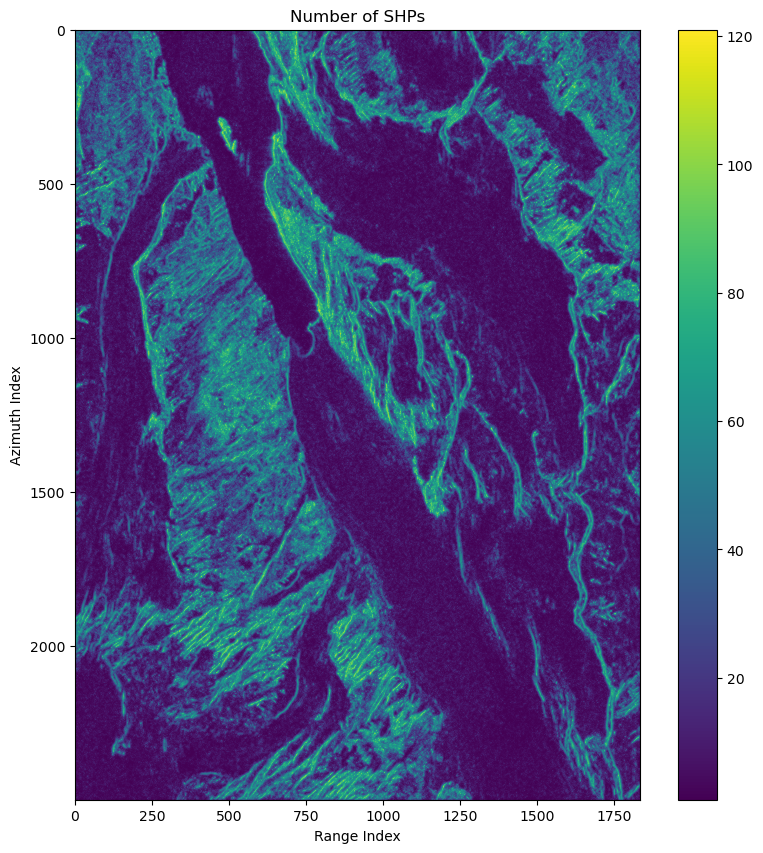

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(shp_num_np)
ax.set(title='Number of SHPs',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

## Select DSs

Here we select DSs as pixels have more than 50 brothers.

In [ ]:
is_ds = shp_num >= 50

The number of DSs:

In [ ]:
cp.count_nonzero(is_ds)

array(740397)

The DSs distribution:

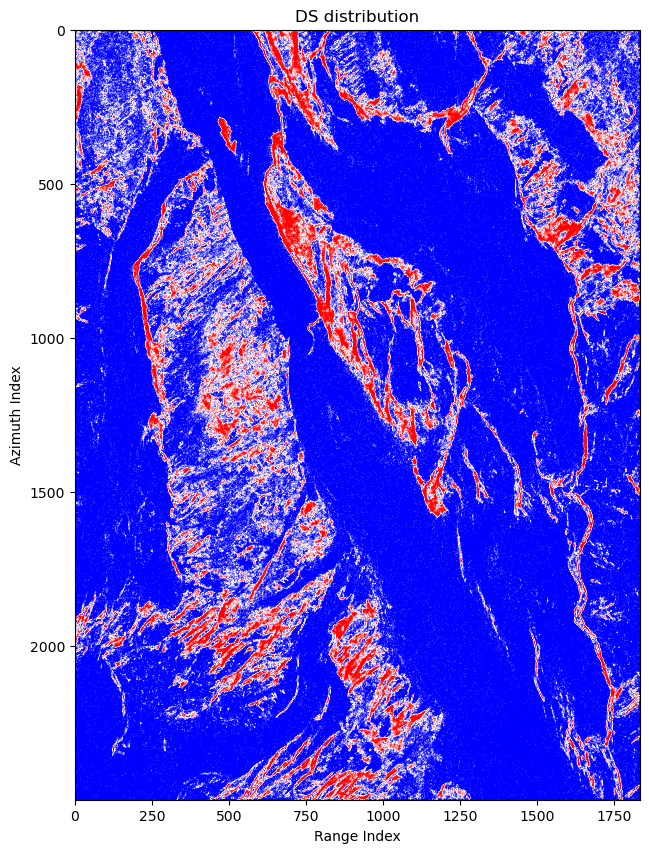

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(cp.asnumpy(is_ds),cmap='bwr')
ax.set(title='DS distribution',xlabel='Range Index',ylabel='Azimuth Index')
fig.show()

## Estimate coherence matrix

In order to save memory, here we only estimate coherence matrix on selected DSs:

In [ ]:
is_shp_ds = is_shp[is_ds]
ds_idx = cp.vstack(cp.where(is_ds)).T
cov, coh = emperical_co_sp(rslc,ds_idx,is_shp_ds)

In [ ]:
ds_idx.shape

(740397, 2)

Plot some coherence matrix:

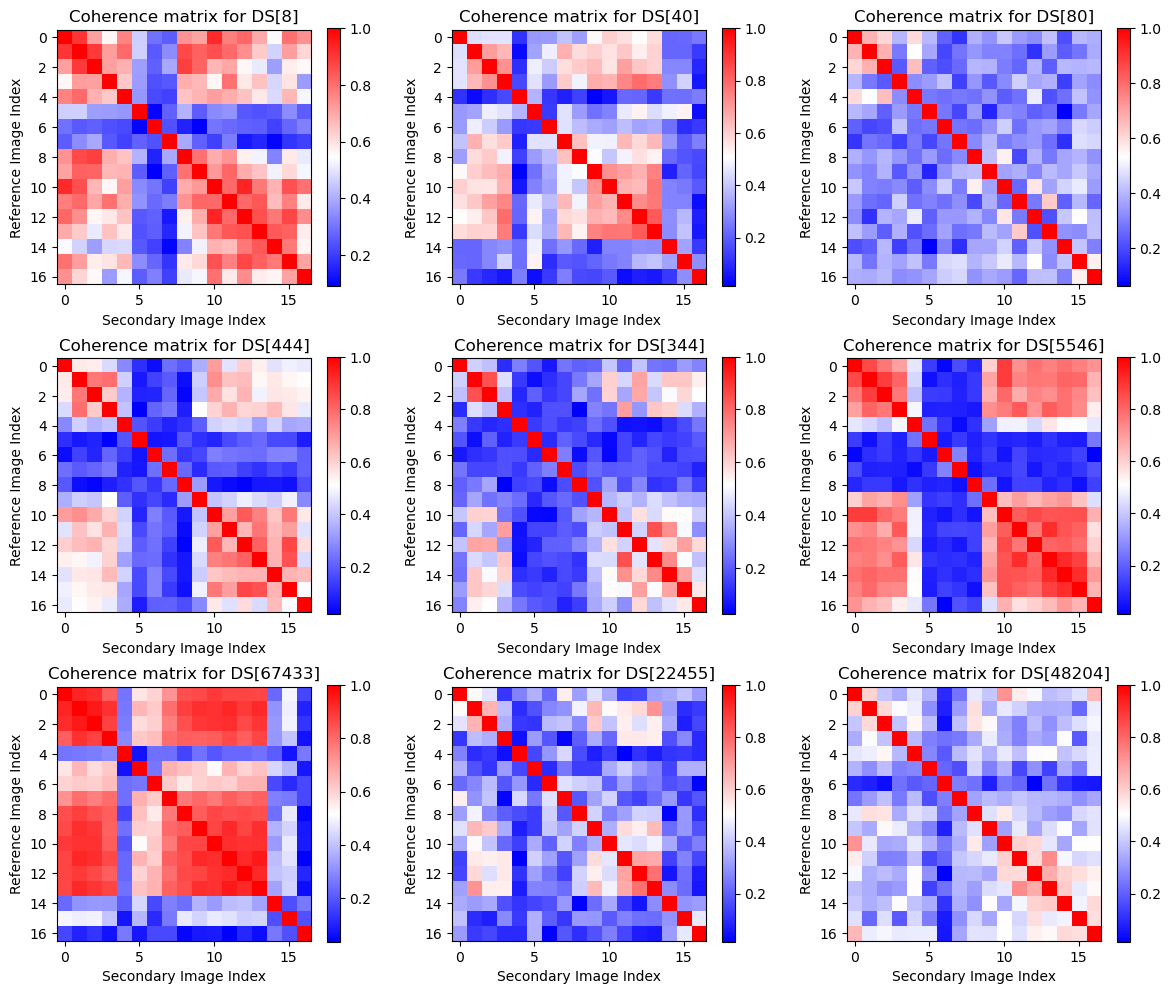

In [ ]:
plot_ds = [8,40,80,444,344,5546,67433,22455,48204]
fig, axes = plt.subplots(3,3,figsize=(12,10))
for i,ax in enumerate(axes.ravel()):
    pcm = ax.imshow(cp.asnumpy(abs(coh[plot_ds[i]])),cmap='bwr')
    ax.set(title=f'Coherence matrix for DS[{plot_ds[i]}]',xlabel='Secondary Image Index',ylabel='Reference Image Index')
    fig.colorbar(pcm,ax=ax)
fig.tight_layout()
fig.show()

In [ ]:
#| hide
isPD = wherePD(coh)
assert cp.count_nonzero(~isPD) == 0

## phase linking

In [ ]:
#| hide
def emi_all(coh:cp.ndarray, #coherence ,dtype cupy.complex
       )-> tuple[cp.ndarray,cp.ndarray,cp.ndarray]: # estimated phase history `ph`, dtype complex; estimated covariance, dtype complex; minimum eigvalue, dtype float
    coh_mag = abs(coh)
    coh_mag_inv = cp.linalg.inv(coh_mag)
    min_eigval, min_eig = cp.linalg.eigh(coh_mag_inv*coh)
    min_eigval = min_eigval[...,0]
    min_eig = min_eig[...,0]
    min_eig = min_eig*cp.sqrt(min_eig.shape[-1])/cp.linalg.norm(min_eig,axis=-1)[...,None] # equality constrain
    min_eig = 1/min_eig.conj()
    abs_min_eig = abs(min_eig)

    estimated_coh = min_eigval[:,None,None]*coh_mag*cp.matmul(min_eig[...,None],min_eig[...,None,:].conj())
    return min_eig/abs_min_eig, estimated_coh, min_eigval

In [ ]:
#| hide
def emi(coh:cp.ndarray, #coherence ,dtype cupy.complex
       )-> tuple[cp.ndarray,cp.ndarray,cp.ndarray]: # estimated phase history `ph`, dtype complex; estimated covariance, dtype complex; minimum eigvalue, dtype float
    coh_mag = abs(coh)
    coh_mag_inv = cp.linalg.inv(coh_mag)
    min_eig = cp.linalg.eigh(coh_mag_inv*coh)[1][...,0]
    return min_eig/abs(min_eig)

In [ ]:
%%time
ph_new = emi(coh)

CPU times: user 586 ms, sys: 365 ms, total: 951 ms
Wall time: 974 ms


Still under construction......